In [1]:
import random
import shutil
import torch
import copy
import onnx
import json
import cv2
import os

# import tflite_runtime.interpreter as tflite
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import torch.optim as optim
import mediapipe as mp
import torch.nn as nn
import pandas as pd
import numpy as np

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from onnx_tf.backend import prepare
from datetime import timedelta
from torchinfo import summary 
from tqdm import tqdm, trange

# Selecting a device for training

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", DEVICE)

Current device: cuda


# Settings

In [3]:
# File directories
DATA_DIR       = './asl-signs/'
LANDMARK_FILES = 'train_landmark_files'
CSV_FILE       = 'train.csv'
ID_TO_SIGN_MAP = 'sign_to_prediction_index_map.json'

#Dataset settings
VAL_PART    = 0.1
TEST_PART   = 0.1
BATCH_SIZE  = 128
NUM_CLASSES = 250
MAX_ROWS    = 543 # Face - 468, Pose - 33, Hands - 21
MAX_FRAMES  = 20
SHUFFLE     = True
NUM_WORKERS = 0
PIN_MEMORY  = False

# Training settings
PRETRAINING = True
LR           = 1e-3
WEIGHT_DECAY = 1e-5
NUM_EPOCHS   = 30

# Scheduler settings
T_0     = 1
T_MULT  = 2
ETA_MIN = 5e-5

# Distribution of classes in the dataset

In [4]:
parquets = pd.read_csv(os.path.join(DATA_DIR, CSV_FILE))
parquets.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


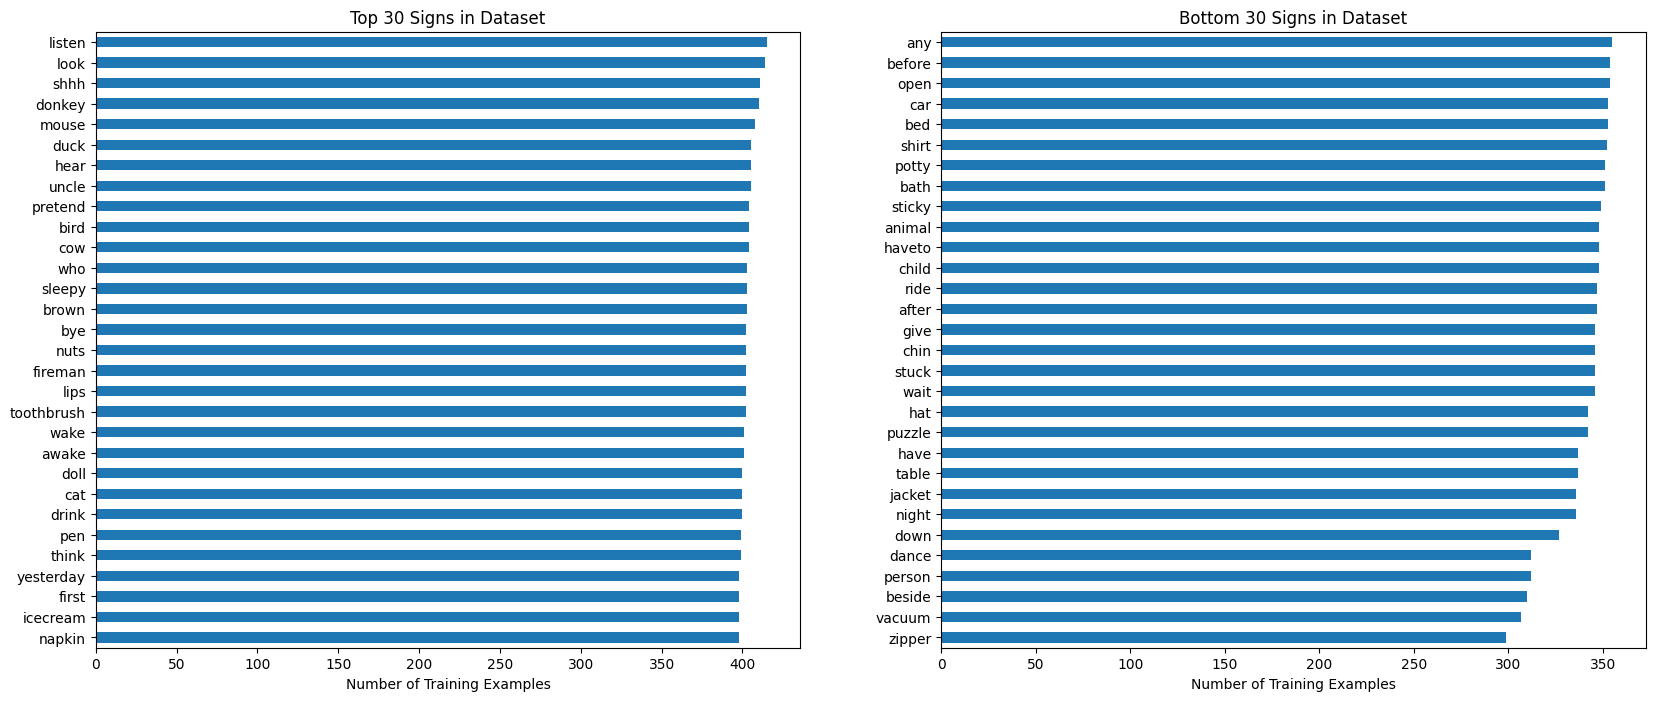

In [5]:
NUM_2_SHOW = 30

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))

parquets['sign'].value_counts().head(NUM_2_SHOW).sort_values(ascending = True).plot(
    kind = "barh", title = f'Top {NUM_2_SHOW} Signs in Dataset', xlabel = 'Number of Training Examples', ylabel = '', ax = ax1)

parquets['sign'].value_counts().tail(NUM_2_SHOW).sort_values(ascending = True).plot(
    kind = "barh", title = f'Bottom {NUM_2_SHOW} Signs in Dataset', xlabel = 'Number of Training Examples', ylabel = '', ax = ax2)

plt.show()

# Class indexes

In [6]:
def read_json(path):
    
    with open(path, "r") as file:
        json_data = json.load(file)
        
    return json_data

In [26]:
sign_2_id_map = read_json(os.path.join(DATA_DIR, ID_TO_SIGN_MAP))
id_2_sign_map = {id: sign for sign, id in sign_2_id_map.items()}

{0: 'TV',
 1: 'after',
 2: 'airplane',
 3: 'all',
 4: 'alligator',
 5: 'animal',
 6: 'another',
 7: 'any',
 8: 'apple',
 9: 'arm',
 10: 'aunt',
 11: 'awake',
 12: 'backyard',
 13: 'bad',
 14: 'balloon',
 15: 'bath',
 16: 'because',
 17: 'bed',
 18: 'bedroom',
 19: 'bee',
 20: 'before',
 21: 'beside',
 22: 'better',
 23: 'bird',
 24: 'black',
 25: 'blow',
 26: 'blue',
 27: 'boat',
 28: 'book',
 29: 'boy',
 30: 'brother',
 31: 'brown',
 32: 'bug',
 33: 'bye',
 34: 'callonphone',
 35: 'can',
 36: 'car',
 37: 'carrot',
 38: 'cat',
 39: 'cereal',
 40: 'chair',
 41: 'cheek',
 42: 'child',
 43: 'chin',
 44: 'chocolate',
 45: 'clean',
 46: 'close',
 47: 'closet',
 48: 'cloud',
 49: 'clown',
 50: 'cow',
 51: 'cowboy',
 52: 'cry',
 53: 'cut',
 54: 'cute',
 55: 'dad',
 56: 'dance',
 57: 'dirty',
 58: 'dog',
 59: 'doll',
 60: 'donkey',
 61: 'down',
 62: 'drawer',
 63: 'drink',
 64: 'drop',
 65: 'dry',
 66: 'dryer',
 67: 'duck',
 68: 'ear',
 69: 'elephant',
 70: 'empty',
 71: 'every',
 72: 'eye',
 

In [8]:
parquets['id'] = parquets["sign"].map(lambda sign: sign_2_id_map[sign])
parquets.head()

,path,participant_id,sequence_id,sign,id
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


# Landmark data example

In [9]:
EXAMPLE_SIGN  = 'shhh'

lms = parquets.query(f'sign == "{EXAMPLE_SIGN}"')['path'].values[0]
lms = pq.read_table(os.path.join(DATA_DIR, lms)).to_pandas()

lms.head()

,frame,row_id,type,landmark_index,x,y,z
0,14,14-face-0,face,0,0.432380,0.375417,-0.044000
1,14,14-face-1,face,1,0.437980,0.349091,-0.070176
2,14,14-face-2,face,2,0.429624,0.360922,-0.040331
3,14,14-face-3,face,3,0.430260,0.315678,-0.049688
4,14,14-face-4,face,4,0.441155,0.338613,-0.073218


# Frames per file

In [10]:
if os.path.isfile('./frames_per_file.txt'):
    with open('./frames_per_file.txt', 'r') as file:

        frames = file.read()
        frames = frames.split()
        frames = list(map(int, frames))

        parquets['n_frames'] = frames

else: 
    frames = np.zeros(len(parquets), dtype = 'int32')

    for i in tqdm(range(len(parquets))):
        frms = pq.read_table(os.path.join(DATA_DIR, parquets.iloc[i]['path']), columns = ['frame']).to_pandas()
        frames[i] = len(pd.unique(frms.squeeze()))

    with open('./frames_per_file.txt', 'w') as file:
        for val in frames:
            file.write(str(val))
            file.write(' ')

parquets['n_frames'] = frames
parquets.head()

,path,participant_id,sequence_id,sign,id,n_frames
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25,23
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232,11
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48,105
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23,12
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164,18


# Visualization of Landmarks

In [11]:
def show_frame(df, label, frame_id):
    
    df = df.dropna()
    
    fig, axs = plt.subplots(1, 4, figsize = (24, 6))
    frame = df[df['frame'] == frame_id]

    hands_edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]
    
    pose_edges = [(15, 21), (16, 20), (18, 20), (3, 7), (14, 16), (23, 25), (28, 30), (11, 23), (27, 31), 
                  (6, 8), (15, 17), (24, 26), (16, 22), (4, 5), (5, 6), (29, 31), (12, 24), (23, 24), (0, 1), 
                  (9, 10), (1, 2), (0, 4), (11, 13), (30, 32), (28, 32), (15, 19), (16, 18), (25, 27), (26, 28),
                  (12, 14), (17, 19), (2, 3), (11, 12), (27, 29), (13, 15)]

    for ax, type in zip(axs, ["face", "pose", "right_hand", "left_hand"]):
        
        lm = frame.query(f'type == "{type}"')

        ax.set_title(type, fontsize = 15)
        ax.scatter(lm['x'], -lm['y'])

        xs     = lm['x'].values
        ys     = lm['y'].values
        lm_ids = lm['landmark_index'].values

        for x, y, id in zip(xs, ys, lm_ids):
            ax.text(x, -y, id, fontsize = 6)

        if (type == 'right_hand' or type == 'left_hand') and len(xs) > 0:
            for edge in hands_edges:
                ax.plot([xs[edge[0]], xs[edge[1]]], [-ys[edge[0]], -ys[edge[1]]], color = 'salmon')

        elif type == 'pose':
            for edge in pose_edges:
                ax.plot([xs[edge[0]], xs[edge[1]]], [-ys[edge[0]], -ys[edge[1]]], color = 'salmon')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.suptitle(f'Sign: "{label}", Frame: {frame_id}', fontsize = 20)

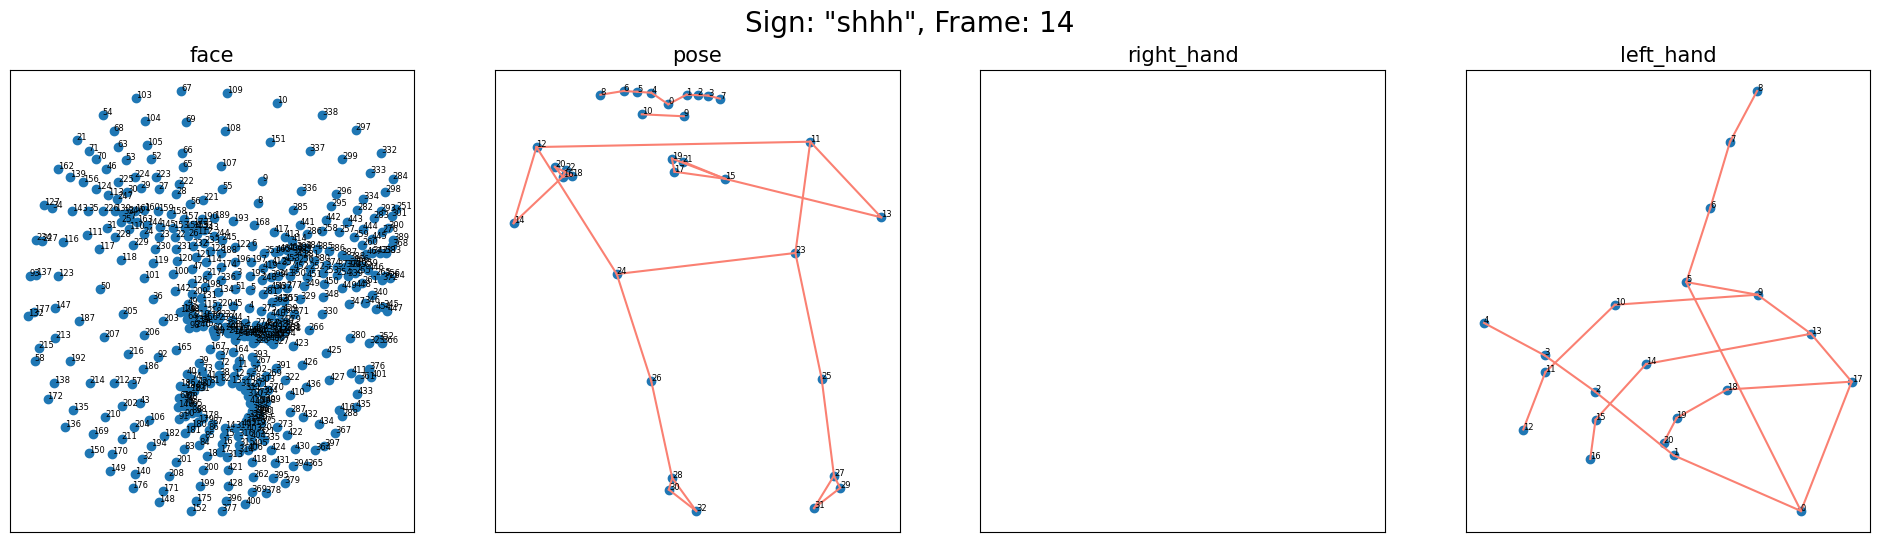

In [12]:
def show_frames_seq(df, label, start_frame, n_frames):

    frames = np.linspace(start_frame, start_frame + n_frames, n_frames, dtype = int, endpoint = True)

    for i in range(n_frames):
        show_frame(df, label, frames[i])
        
    plt.show()

show_frames_seq(lms, EXAMPLE_SIGN, lms['frame'][0], 1)

# Creating a dataset

In [13]:
class sign_Dataset(Dataset):
    
    def __init__(self, parq_dirs):
        self.parq_dirs = parq_dirs

    def __getitem__(self, id):
        
        lms = pq.read_table(os.path.join(DATA_DIR, self.parq_dirs.iloc[id]['path']), columns = ['x', 'y', 'z']).to_pandas()
        lms = lms.fillna(0)
        lms = lms.to_numpy(dtype = 'float').reshape(-1, MAX_ROWS, lms.shape[1])

        n_frames = lms.shape[0]
        id = 0 if n_frames == MAX_FRAMES else random.randint(0, n_frames - MAX_FRAMES)

        return lms[id:id+MAX_FRAMES, :, :], self.parq_dirs.iloc[id]['id']

    def __len__(self):
        return len(self.parq_dirs)

# Split train.csv for training and validation

In [14]:
parquets = parquets[parquets['n_frames'] >= MAX_FRAMES]
dataset = sign_Dataset(parquets)

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
ids = list(range(dataset_size))

n_test  = int(np.floor(TEST_PART * dataset_size))
n_val   = int(np.floor(VAL_PART * dataset_size))
n_train = dataset_size - n_val - n_test

if SHUFFLE :
    np.random.shuffle(ids)
    
train_ids, val_ids, test_ids = ids[n_val + n_test:], ids[n_test:n_val + n_test], ids[:n_test]

train_sampler = SubsetRandomSampler(train_ids)
val_sampler   = SubsetRandomSampler(val_ids)
test_sampler  = SubsetRandomSampler(test_ids)

# Creating a Dataloader

In [15]:
data_loader = {
    'train':
        DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY),
    'valid':
        DataLoader(dataset, batch_size = BATCH_SIZE, sampler = val_sampler, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY),
    'test':
        DataLoader(dataset, batch_size = BATCH_SIZE, sampler = test_sampler, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)
}

df, label = next(iter(data_loader['train']))
print(df.shape)
print(label.shape)

torch.Size([128, 20, 543, 3])
torch.Size([128])


# Creating a model

In [16]:
class Net(nn.Module):
    
    def __init__(self, in_features, num_classes):
        super(Net, self).__init__()

       
        self.l1 = nn.Sequential(nn.Linear(in_features, 256),
                               nn.BatchNorm1d(256),
                               nn.ReLU(),
                                # nn.Dropout(p = 0.3),
                               )
        self.l2 = nn.Sequential(nn.Linear(256, 128),
                               nn.BatchNorm1d(128),
                               nn.ReLU(),
                                nn.Dropout(p = 0.3),
                               )
        self.l3 = nn.Sequential(nn.Linear(128, 64),
                               nn.BatchNorm1d(64),
                               nn.ReLU(),
                                # nn.Dropout(p = 0.3),
                               )
        self.l4 = nn.Sequential(nn.Linear(64, 32),
                               nn.BatchNorm1d(32),
                               nn.ReLU(),
                                nn.Dropout(p = 0.3),
                               )
        self.l5 = nn.Sequential(nn.Linear(32, 16),
                               nn.BatchNorm1d(16),
                               nn.ReLU(),
                                # nn.Dropout(p = 0.3),
                               )
        self.l6 = nn.Sequential(nn.Linear(16, num_classes),
                               nn.BatchNorm1d(num_classes),
                               nn.ReLU(),
                                nn.Dropout(p = 0.3),
                               )
        self.flatten = nn.Flatten()


    def forward(self, x):

        x = self.flatten(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)

        return x
    
model = Net(MAX_ROWS * MAX_FRAMES * 3, NUM_CLASSES).to(DEVICE)

In [17]:
criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(model.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = T_0, T_mult = T_MULT, eta_min = ETA_MIN)


In [18]:
train_losses = []
val_losses   = []
train_acc    = []
val_acc      = []

lr = [LR]

def train_model(model, criterion, optimizer, num_epochs = NUM_EPOCHS):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in (pbar := trange(num_epochs)):
        for phase in['train', 'valid']:

            if phase == 'train':
                model.train()

            else:
                model.eval()

            total = 0
            running_loss     = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(data_loader[phase], position = 1, leave = False, desc = phase):
                inputs = inputs.float().to(DEVICE)
                labels = labels.to(DEVICE)

                outputs  = model(inputs)
                _, preds = torch.max(outputs, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':                   
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss     += loss.item()
                running_corrects += torch.sum(preds == labels) / inputs.shape[0]
                total += 1

            lr_scheduler.step()
            lr.append(optimizer.param_groups[0]["lr"])

            epoch_loss = running_loss / total
            epoch_acc  = running_corrects.double() / total * 100
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
                
                if best_acc < epoch_acc: 
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts, './best_model.pth')
       
        pbar.set_description(
            f'Avg. train/valid loss: [{train_losses[epoch]:.2f}/{val_losses[epoch]:.2f}], train/valid Accuracy: [{train_acc[epoch]:.2f}%/{val_acc[epoch]:.2f}%]')
        
    return model.load_state_dict(best_model_wts)

if not PRETRAINING:
    model = train_model(model, criterion, optimizer)

# Graphs

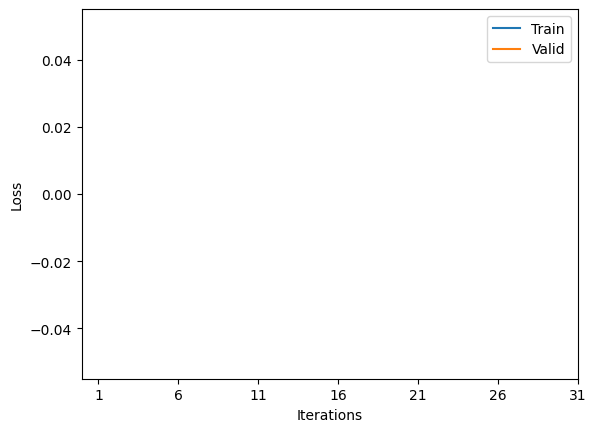

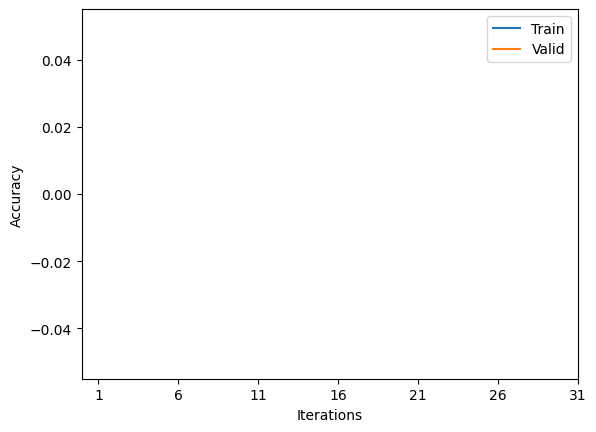

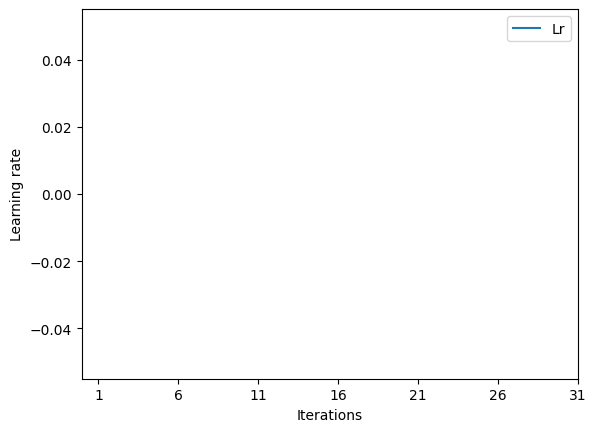

In [19]:
def legend(list_1, label_1, step, title, list_2 = None, label_2 = None):

    plt.plot(list_1[1:], label = label_1)

    if list_2 is not None:
        plt.plot(list_2[1:], label = label_2)

    plt.xticks(range(1, NUM_EPOCHS + step, step))
    plt.xlabel('Iterations')
    plt.ylabel(title)

    plt.legend()
    plt.show()

legend(list_1 = train_losses, label_1 = 'Train', step = 5, title = 'Loss', list_2 = val_losses, label_2 = 'Valid')
legend(list_1 = train_acc, label_1 = 'Train', step = 5, title = 'Accuracy', list_2 = val_acc, label_2 = 'Valid')
legend(list_1 = lr, label_1 = 'Lr', step = 5, title = 'Learning rate')

# Test model

In [30]:
model.load_state_dict(torch.load('./best_model.pth'))
def test_model(loader):

    with torch.no_grad():

        total = 0
        running_acc = 0 

        for i, (inputs, labels) in enumerate(loader):
            
            inputs = inputs.float().to(DEVICE)
            labels = labels.to(DEVICE)

            outputs  = model(inputs)
            _, preds = torch.max(outputs, 1)

            labels = labels.cpu()
            preds  = preds.cpu()
            
            if not i:
                for ex in range(10):

                    print("True label:", id_2_sign_map[labels[ex].item()])
                    print("Prediction:", id_2_sign_map[preds[ex].item()])
                    print("-"*20)

            total += 1
            running_acc += torch.sum(preds == labels) / inputs.shape[0]

        acc = running_acc / total

        print('Accuracy of the network on the {} test images: {:.4f} %'.format(total, 100 * acc))

test_model(data_loader['test'])

True label: TV
Prediction: TV
--------------------
True label: blow
Prediction: blow
--------------------
True label: hair
Prediction: cloud
--------------------
True label: flower
Prediction: flower
--------------------
True label: cloud
Prediction: blow
--------------------
True label: dryer
Prediction: blow
--------------------
True label: orange
Prediction: cloud
--------------------
True label: shirt
Prediction: cloud
--------------------
True label: blow
Prediction: cloud
--------------------
True label: backyard
Prediction: balloon
--------------------
Accuracy of the network on the 42 test images: 12.8286 %


# Video recording to test the model

In [32]:
def format_timedelta(td):

    result = str(td)

    try:
        result, ms = result.split(".")
        
    except ValueError:
        return result + ".00".replace(":", "-")
    
    ms = int(ms)
    ms = round(ms / 1e4)

    return f"{result}.{ms:02}".replace(":", "-")

In [33]:
def get_saving_frames_durations(cap, saving_fps):

    s = []
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)

    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)

    return s

In [34]:
def cut_video(inp_dir):

    SAVING_FRAMES_PER_SECOND = 10

    video     = inp_dir
    filename  = video
    filename += "-opencv"

    if not os.path.isdir(filename):
        os.mkdir(filename)

    cap = cv2.VideoCapture(video)
    fps = cap.get(cv2.CAP_PROP_FPS)

    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)

    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)

    count = 0
    while True:
        is_read, frame = cap.read()

        if not is_read:
            break

        frame_duration = count / fps

        try:
            closest_duration = saving_frames_durations[0]

        except IndexError:
            break

        if frame_duration >= closest_duration:
            frame_duration_formatted = format_timedelta(timedelta(seconds = frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame)

            try:
                saving_frames_durations.pop(0)

            except IndexError:
                pass

        count += 1

    return filename

In [35]:
def create_test_df(input_dir):

    mp_holistic = mp.solutions.holistic
    mp_drawing  = mp.solutions.drawing_utils

    face_list       = []
    left_hand_list  = []
    right_hand_list = []
    pose_list       = []

    iter_f = 0

    for filename in os.listdir(input_dir):
        fil_n = input_dir + '/' + filename

        image = cv2.imread(fil_n)

        ## Setup mediapipe instance
        with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:

            # Recolor image to RGB
            image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            results = holistic.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # 1. Draw face landmarks
            mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                        mp_drawing.DrawingSpec(color = (80, 110, 10), thickness = 1, circle_radius = 1),
                                        mp_drawing.DrawingSpec(color = (80, 256, 121), thickness = 1, circle_radius = 1)
                                        )

            # 2. Right hand
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                        mp_drawing.DrawingSpec(color = (80, 22, 10), thickness = 2, circle_radius = 4),
                                        mp_drawing.DrawingSpec(color = (80, 44, 121), thickness = 2, circle_radius = 2)
                                        )

            # 3. Left Hand          
            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                        mp_drawing.DrawingSpec(color = (121, 22, 76), thickness=2, circle_radius=4),
                                        mp_drawing.DrawingSpec(color = (121, 44, 250), thickness=2, circle_radius=2)
                                        )

            # 4. Draw pose landmarks           
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                                        )

        # 1. Face Dataframe
        len_face = 468

        for itr in range(len_face):
            if results.face_landmarks:
                lst = [iter_f, 'face', itr, results.face_landmarks.landmark[itr].x,
                       results.face_landmarks.landmark[itr].y, results.face_landmarks.landmark[itr].z]
                
            else:
                lst = [iter_f, 'face', itr, None,None,None]

            face_list.append(lst)

        # 2. Left_hand Dataframe
        len_lft = 21

        for itr in range(len_lft):
            if results.left_hand_landmarks:
                lst = [iter_f, 'left_hand', itr, results.left_hand_landmarks.landmark[itr].x,
                       results.left_hand_landmarks.landmark[itr].y, results.left_hand_landmarks.landmark[itr].z]
                
            else:
                lst = [iter_f, 'left_hand', itr, None,None,None]

            left_hand_list.append(lst)

        # 3. Right_hand Dataframe
        len_rgt = 21

        for itr in range(len_rgt):
            if results.right_hand_landmarks:
                lst = [iter_f, 'right_hand', itr, results.right_hand_landmarks.landmark[itr].x,
                       results.right_hand_landmarks.landmark[itr].y, results.right_hand_landmarks.landmark[itr].z]
                
            else:
                lst = [iter_f, 'right_hand', itr, None,None,None]

            right_hand_list.append(lst)


        # 2. Pose Dataframe
        len_pose = 33

        for itr in range(len_pose):
            if results.pose_landmarks:
                lst = [iter_f, 'pose', itr, results.pose_landmarks.landmark[itr].x,
                       results.pose_landmarks.landmark[itr].y, results.pose_landmarks.landmark[itr].z]
                
            else:
                lst = [iter_f, 'pose', itr, None,None,None]

            pose_list.append(lst)

        iter_f += 1

    df_face       = pd.DataFrame(face_list, columns = ['frame', 'type', 'landmark_index', 'x', 'y', 'z'])
    df_left_hand  = pd.DataFrame(left_hand_list, columns = ['frame', 'type', 'landmark_index', 'x', 'y', 'z'])
    df_right_hand = pd.DataFrame(right_hand_list, columns = ['frame', 'type', 'landmark_index', 'x', 'y', 'z'])
    df_pose       = pd.DataFrame(pose_list, columns = ['frame', 'type', 'landmark_index', 'x', 'y', 'z'])
    df            = pd.concat([df_face, df_left_hand, df_right_hand, df_pose], ignore_index = True)

    return df

In [36]:
def create_video():

    cap = cv2.VideoCapture(0)
    cap.set(3, 640)
    cap.set(4, 480)

    out = cv2.VideoWriter('output.mp4', 0x7634706d, 30.0, (640, 480))

    while True:
        
        _, frame = cap.read()
        out.write(frame)
        cv2.imshow('frame', frame)
        c = cv2.waitKey(1)

        if c & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return out

In [37]:
def get_dataframe():

    if os.path.isdir('./output.mp4-opencv'):
        shutil.rmtree('./output.mp4-opencv')

    create_video() 
    video = 'output.mp4'

    inp_dir = cut_video(video)

    return create_test_df(inp_dir)

In [67]:
model.eval()
lms = get_dataframe()

data = lms[['x', 'y', 'z']]
data = data.fillna(0)
data = data.to_numpy(dtype = 'float')
data = data.reshape(1, -1, MAX_ROWS, 3)
data = torch.tensor(data[:, :MAX_FRAMES, :, :]).float().to(DEVICE)

output = model(data)
_, label = torch.max(output, 1)

label = label.cpu().item()

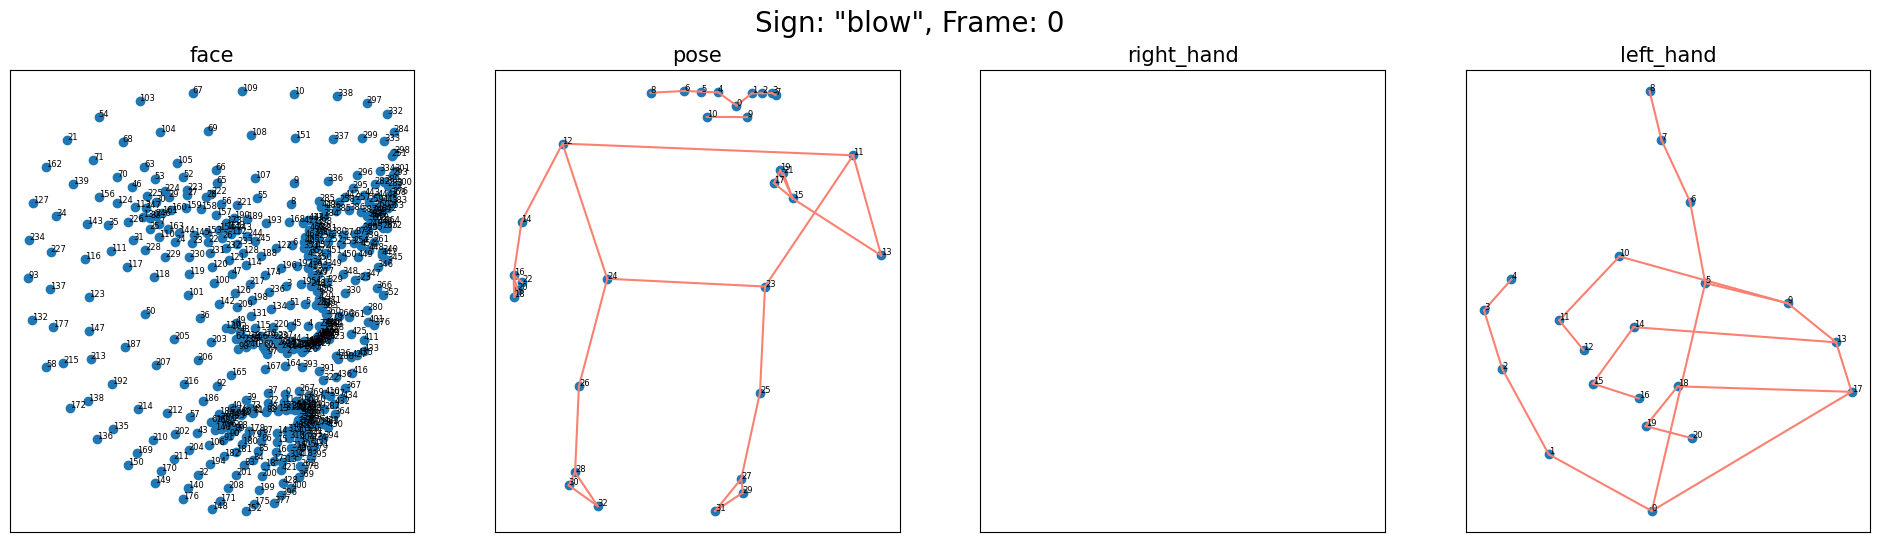

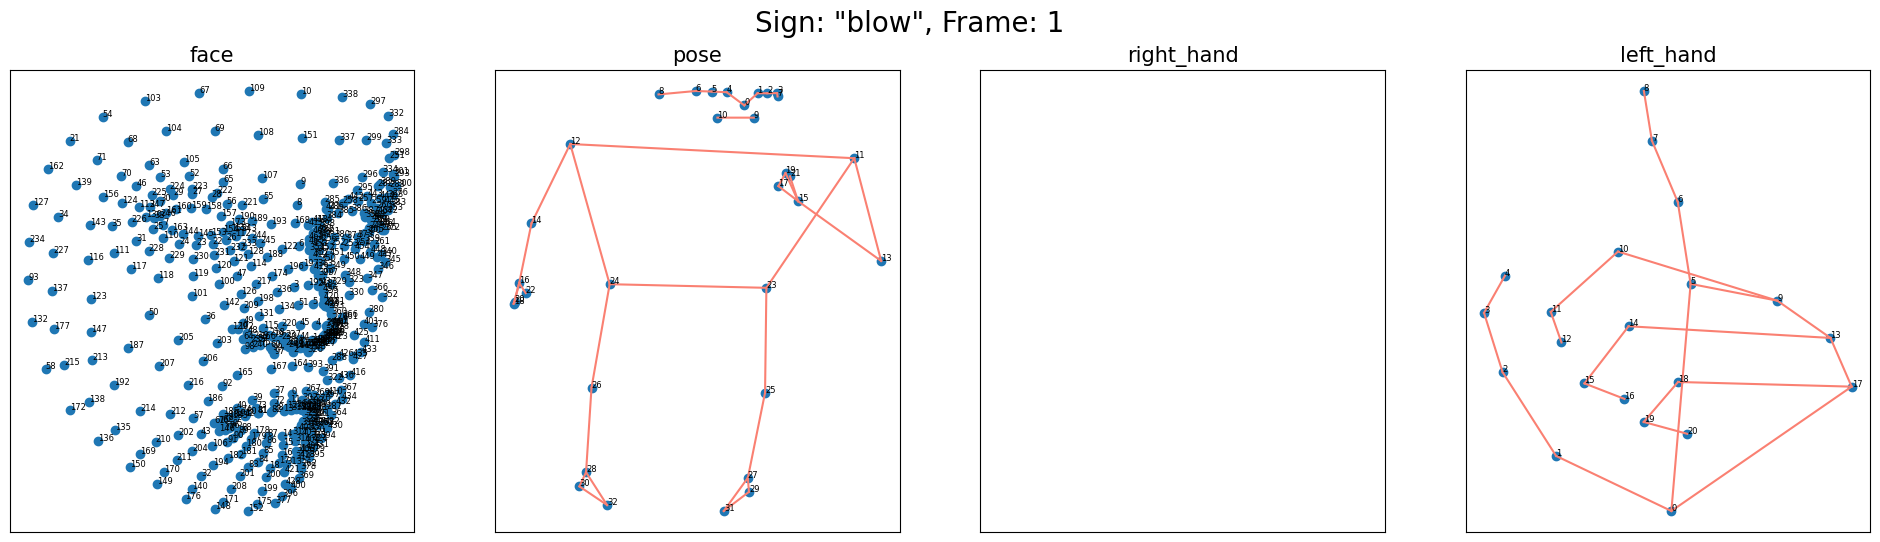

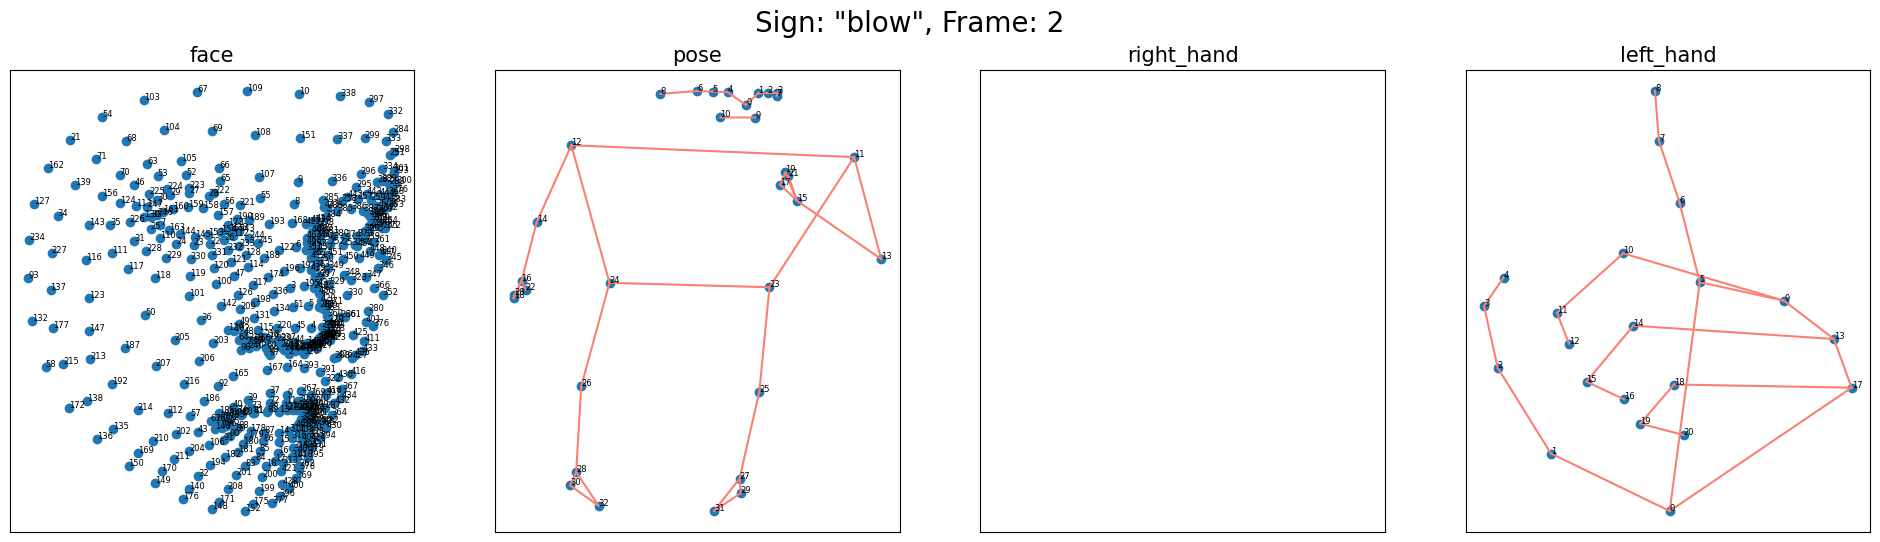

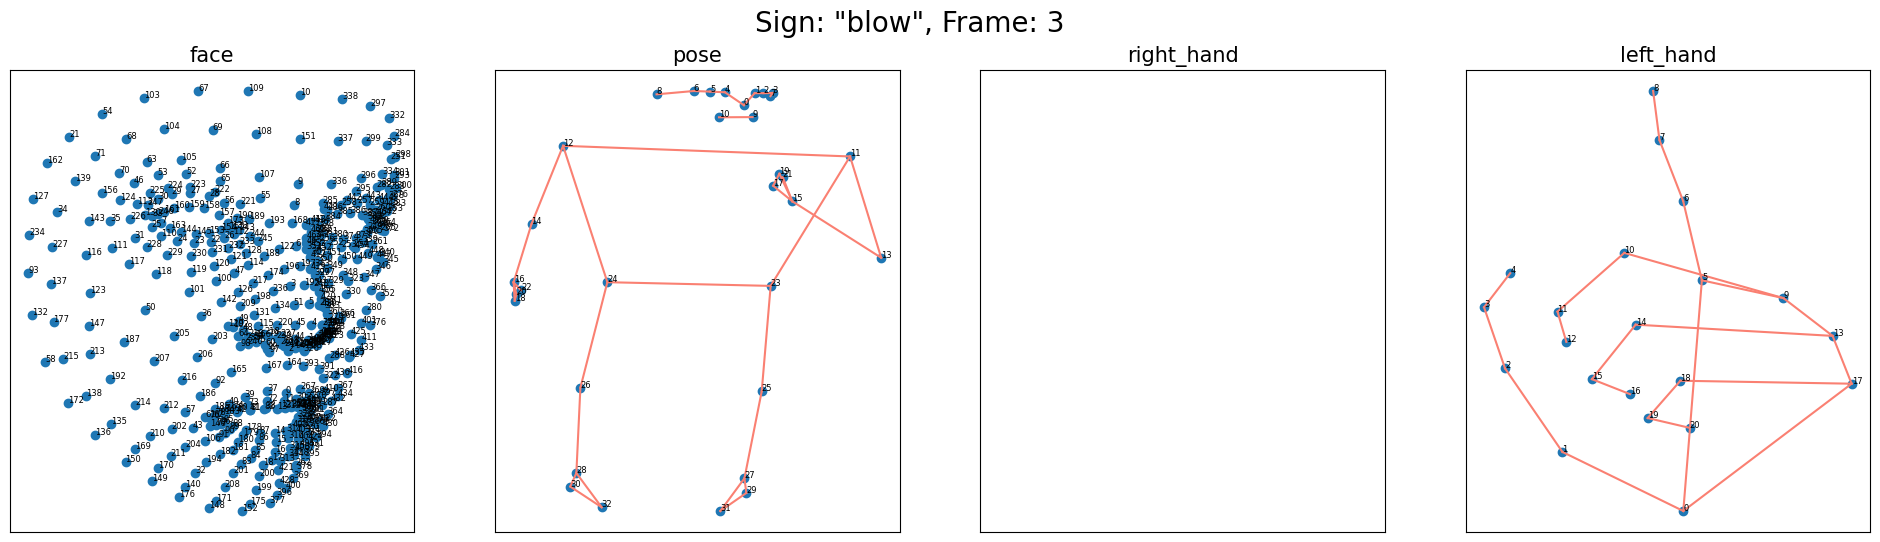

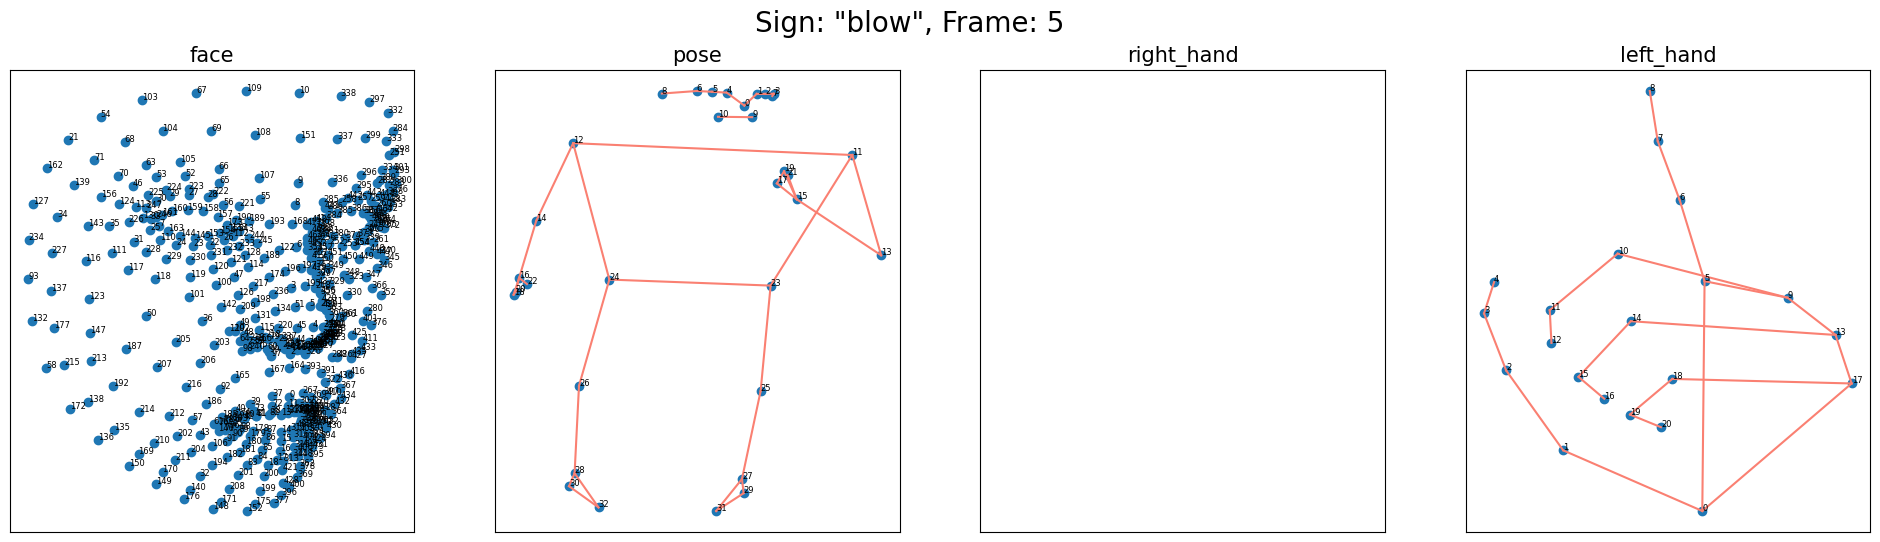

In [68]:
show_frames_seq(lms, id_2_sign_map[label], lms['frame'][0], 5)

# Convert to TFLite

In [ ]:
class Net_infe(Net):#наследуемся от предыдущей модели

    def __init__(self):
        super().__init__()

        self.softmax = nn.Softmax()

    def forward(self, x):
        x = torch.where(torch.isnan(x), torch.tensor(0.0,dtype=torch.float32).to(DEVICE),x)
        x = torch.mean(x, dim = 0, keepdim = False)
        x = self.flatten(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        return self.softmax(x)
    
model_infe = Net_infe()

In [ ]:
model_infe.load_state_dict(torch.load('/kaggle/working/model.pth'), strict = False)

model_infe = model_infe.to(DEVICE)

In [ ]:
input_size = (BATCH_SIZE, MAX_ROWS, 3)
saved_onnx = 'model.onnx'
sample_input = torch.rand(input_size).to(DEVICE)
model_infe.eval()
preds = model_infe(sample_input)
preds

In [ ]:
torch.onnx.export(
    model_infe,
    sample_input,
    saved_onnx,
    verbose=False,
    input_names=['inputs'],
    output_names=['outputs'],
    opset_version=11
)

In [ ]:
model_onnx = onnx.load(saved_onnx)
onnx.checker.check_model(model_onnx)

print(onnx.helper.printable_graph(model_onnx.graph))

In [ ]:
tf_rep = prepare(model_onnx)

In [ ]:
pb_path = "model.pb"
tf_rep.export_graph(pb_path)

assert os.path.exists(pb_path)
print(".pb model converted successfully.")

In [ ]:
input_nodes = tf_rep.inputs
output_nodes = tf_rep.outputs

print("The names of the input nodes are: {}".format(input_nodes))
print("The names of the output nodes are: {}".format(output_nodes))

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(pb_path)
tflite_rep = converter.convert()

tflite_model_path = 'model.tflite'

with open(tflite_model_path, 'wb') as f:
    f.write(tflite_rep)

In [ ]:
!zip submission.zip $tflite_model_path

In [ ]:
interpreter = tflite.Interpreter(tflite_model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

list_label = train_df['sign'].unique()

for i in range(10):

    frames = load_relevant_data_subset(f'{train_df.iloc[i].path}')
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])

    print(f"Predicted label: {p2s_map[sign]}, Actual Label: {train_df.iloc[i].sign}")